In [20]:
# ✅ 必要ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

# ✅ データ読み込み
PATH = '../data/'
X = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

# ✅ Age 欠損処理
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])

# ✅ 数値カラム欠損補完
for col in X.columns:
    if X[col].isnull().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)

# ✅ 不要カラム削除
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

# ✅ 目的変数分離
y = X["Drafted"]
X = X.drop(columns=["Drafted"])

# ✅ School, Player_Type, Position_Type 削除
X = X.drop(columns=["School", "Player_Type", "Position_Type"])
test = test.drop(columns=["School", "Player_Type", "Position_Type"])

# ✅ Position Target Encoding
position_stats = X.copy()
position_stats["Drafted"] = y
position_target_map = position_stats.groupby("Position")["Drafted"].mean()
X["Position_encoded"] = X["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(X["Position_encoded"].mean())

# ✅ Position Group Encoding (fold-safe)
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

X["Position_group"] = X["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["Position_group_encoded"] = 0
for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    group_map = X_train.assign(Drafted=y_train).groupby("Position_group")["Drafted"].mean()
    X.loc[val_idx, "Position_group_encoded"] = X.loc[val_idx, "Position_group"].map(group_map)
final_group_map = X.assign(Drafted=y).groupby("Position_group")["Drafted"].mean()
test["Position_group_encoded"] = test["Position_group"].map(final_group_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(X["Position_group_encoded"].mean())

X = X.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])

# ✅ SpeedScore, BurstScore, AgilityScore, ASI, RSA特徴量
X["Weight_lbs"] = X["Weight"] * 2.20462
test["Weight_lbs"] = test["Weight"] * 2.20462

X["SpeedScore"] = X["Weight_lbs"] * (200 / X["Sprint_40yd"]**2)
test["SpeedScore"] = test["Weight_lbs"] * (200 / test["Sprint_40yd"]**2)

X["BurstScore"] = X["Vertical_Jump"] + X["Broad_Jump"]
test["BurstScore"] = test["Vertical_Jump"] + test["Broad_Jump"]

X["AgilityScore"] = X["Shuttle"] + X["Agility_3cone"]
test["AgilityScore"] = test["Shuttle"] + test["Agility_3cone"]

X["ASI"] = 0.5 * X["SpeedScore"] + 0.3 * X["BurstScore"] + 0.2 * X["AgilityScore"]
test["ASI"] = 0.5 * test["SpeedScore"] + 0.3 * test["BurstScore"] + 0.2 * test["AgilityScore"]

rsa_features = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Shuttle", "Agility_3cone"]
for col in rsa_features:
    scaler = MinMaxScaler(feature_range=(0, 10))
    if col in ["Sprint_40yd", "Shuttle", "Agility_3cone"]:
        X[f"RSA_{col}"] = 10 - scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = 10 - scaler.transform(test[[col]])
    else:
        X[f"RSA_{col}"] = scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = scaler.transform(test[[col]])

# ✅ BMI
X["BMI"] = X["Weight"] / (X["Height"]/100)**2
test["BMI"] = test["Weight"] / (test["Height"]/100)**2

# ✅ School特徴量（Top, Drafted Count, Drafted Rate TE）
df_raw = pd.read_csv(PATH + 'train.csv')
test_raw = pd.read_csv(PATH + 'test.csv')
X["School"] = df_raw["School"]
test["School"] = test_raw["School"]

school_stats = X.copy()
school_stats["Drafted"] = y
school_agg = school_stats.groupby("School")["Drafted"].agg(["sum", "count"])
school_agg["Drafted_Rate"] = school_agg["sum"] / school_agg["count"]

top_n = 20
top_schools = school_agg["sum"].sort_values(ascending=False).head(top_n).index.tolist()

X["School_Top"] = X["School"].isin(top_schools).astype(int)
test["School_Top"] = test["School"].isin(top_schools).astype(int)

X["School_Drafted_Count"] = X["School"].map(school_agg["sum"])
test["School_Drafted_Count"] = test["School"].map(school_agg["sum"])
test["School_Drafted_Count"] = test["School_Drafted_Count"].fillna(0)

X["School_Drafted_Rate_TE"] = 0.0
for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    rate_map = X_train.assign(Drafted=y_train).groupby("School")["Drafted"].mean()
    X.loc[val_idx, "School_Drafted_Rate_TE"] = (
        X.loc[val_idx, "School"].map(rate_map).fillna(y.mean())
    )

final_rate_map = X.assign(Drafted=y).groupby("School")["Drafted"].mean()
test["School_Drafted_Rate_TE"] = test["School"].map(final_rate_map)
test["School_Drafted_Rate_TE"] = test["School_Drafted_Rate_TE"].fillna(y.mean())

X = X.drop(columns=["School"])
test = test.drop(columns=["School"])




C:\Users\81807\AppData\Local\Temp\ipykernel_23520\4019545716.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6        0.2739726  0.65632458 0.7109375  0.62895928 0.62895928
 0.65632458 0.62895928 0.7109375  0.71884984 0.6        0.65632458
 0.65632458 0.71884984 0.62895928 0.62895928 0.65632458 0.71884984
 0.62895928 0.65632458 0.65632458 0.62895928 0.62895928 0.65632458
 0.6        0.62895928 0.62895928 0.65632458 0.71884984 0.7109375
 0.62895928 0.7109375  0.71884984 0.62895928 0.65632458 0.62895928
 0.2739726  0.65632458 0.65632458 0.2739726  0.68376068 0.65632458
 0.62895928 0.48275862 0.68376068 0.68376068 0.71884984 0.62895928
 0.62895928 0.62895928 0.7109375  0.62895928 0.71884984 0.65632458
 0.7109375  0.62895928 0.6        0.62895928 0.7109375  0.65632458
 0.62895928 0.62895928 0.71884984 0.71884984 0.68376068 0.7109375
 0.68376068 0.65632458 0.62895928 0.62895928 0.62895928 0.62895928
 

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

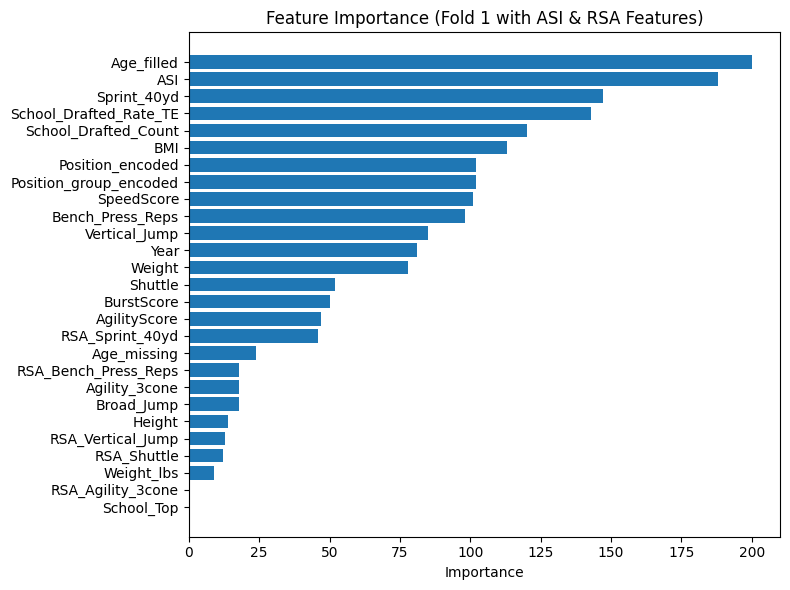

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [21]:
# ✅ LightGBM 訓練
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X.columns

        # ソート（重要度降順）
        sorted_idx = importances.argsort()
        sorted_importances = importances[sorted_idx]
        sorted_feature_names = feature_names[sorted_idx]

        plt.figure(figsize=(8, 6))
        plt.barh(sorted_feature_names, sorted_importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [22]:
# ✅ CatBoost 訓練・AUC計測（単独セル）

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=5.0,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=30,
    verbose=False
)

train_aucs_cat = []
val_aucs_cat = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model_cat.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        use_best_model=True
    )

    y_train_pred = model_cat.predict_proba(X_train)[:, 1]
    y_valid_pred = model_cat.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs_cat.append(train_auc)
    val_aucs_cat.append(val_auc)

    print(f"✅ [CatBoost] Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\n✅ [CatBoost] Average Train AUC: {np.mean(train_aucs_cat):.4f}")
print(f"✅ [CatBoost] Average Validation AUC: {np.mean(val_aucs_cat):.4f}")


✅ [CatBoost] Fold 1 - Train AUC: 0.9354, Validation AUC: 0.8587
✅ [CatBoost] Fold 2 - Train AUC: 0.8839, Validation AUC: 0.8502
✅ [CatBoost] Fold 3 - Train AUC: 0.8684, Validation AUC: 0.8277
✅ [CatBoost] Fold 4 - Train AUC: 0.8630, Validation AUC: 0.8034
✅ [CatBoost] Fold 5 - Train AUC: 0.8550, Validation AUC: 0.8587

✅ [CatBoost] Average Train AUC: 0.8811
✅ [CatBoost] Average Validation AUC: 0.8397


In [23]:
# ✅ XGBoost 訓練・AUC計測（単独セル）

from xgboost import XGBClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.015,
    reg_alpha=15.0,
    reg_lambda=15.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='auc'
)


train_aucs_xgb = []
val_aucs_xgb = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_train_pred = model_xgb.predict_proba(X_train)[:, 1]
    y_valid_pred = model_xgb.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs_xgb.append(train_auc)
    val_aucs_xgb.append(val_auc)

    print(f"✅ [XGBoost] Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\n✅ [XGBoost] Average Train AUC: {np.mean(train_aucs_xgb):.4f}")
print(f"✅ [XGBoost] Average Validation AUC: {np.mean(val_aucs_xgb):.4f}")


✅ [XGBoost] Fold 1 - Train AUC: 0.8754, Validation AUC: 0.8588
✅ [XGBoost] Fold 2 - Train AUC: 0.8806, Validation AUC: 0.8480
✅ [XGBoost] Fold 3 - Train AUC: 0.8831, Validation AUC: 0.8163
✅ [XGBoost] Fold 4 - Train AUC: 0.8825, Validation AUC: 0.8067
✅ [XGBoost] Fold 5 - Train AUC: 0.8746, Validation AUC: 0.8596

✅ [XGBoost] Average Train AUC: 0.8792
✅ [XGBoost] Average Validation AUC: 0.8379


In [24]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# LightGBM モデル
from lightgbm import LGBMClassifier
model_lgb = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# CatBoost モデル
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=5.0,
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

# XGBoost モデル（過学習抑制済バージョン）
from xgboost import XGBClassifier
model_xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.015,
    reg_alpha=15.0,
    reg_lambda=15.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='auc'
)

# VotingClassifier 設定（soft voting で確率平均）
voting_clf = VotingClassifier(
    estimators=[
        ('lgb', model_lgb),
        ('cat', model_cat),
        ('xgb', model_xgb)
    ],
    voting='soft',
    n_jobs=-1
)

# Cross-Validation で AUC を確認
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(
    voting_clf, X, y,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

print(f"\n✅ [VotingClassifier] Average Validation AUC: {auc_scores.mean():.5f}")
print(f"✅ Fold-wise AUCs: {auc_scores}")



✅ [VotingClassifier] Average Validation AUC: 0.84398
✅ Fold-wise AUCs: [0.82104698 0.87257618 0.85861212 0.81958617 0.84805839]


In [25]:
# 各カラムごとの欠損数を表示
missing_counts = X.isnull().sum()
print("✅ 各カラムの欠損数:\n", missing_counts[missing_counts > 0])

# 欠損が1件でもある場合の合計件数
total_missing = missing_counts.sum()
print(f"\n✅ 欠損合計件数: {total_missing}")

# 欠損行のインデックスも確認する場合
if total_missing > 0:
    missing_rows = X[X.isnull().any(axis=1)]
    print("\n✅ 欠損行サンプル（最大5件表示）:")
    print(missing_rows.head())
else:
    print("\n✅ 欠損はありません。")


✅ 各カラムの欠損数:
 Series([], dtype: int64)

✅ 欠損合計件数: 0

✅ 欠損はありません。


In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np


In [39]:
# LightGBM
model_lgb = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# CatBoost
model_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=5.0,
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

# XGBoost
model_xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.015,
    reg_alpha=15.0,
    reg_lambda=15.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False
)

# RandomForest
model_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)


In [40]:
# 重み設定
weights = [1, 2, 2, 1]  # LGB, Cat, XGB, RF

voting_clf = VotingClassifier(
    estimators=[
        ('lgb', model_lgb),
        ('cat', model_cat),
        ('xgb', model_xgb),
        ('rf', model_rf)
    ],
    voting='soft',
    weights=weights,
    n_jobs=-1
)

# 5-Fold CVでValidation AUC確認
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    voting_clf.fit(X_train, y_train)
    y_valid_pred = voting_clf.predict_proba(X_valid)[:, 1]

    auc = roc_auc_score(y_valid, y_valid_pred)
    auc_scores.append(auc)
    print(f"✅ [Weighted Voting] Fold {fold + 1} Validation AUC: {auc:.5f}")

print(f"\n✅ [Weighted Voting] Average Validation AUC: {np.mean(auc_scores):.5f}")


✅ [Weighted Voting] Fold 1 Validation AUC: 0.82245
✅ [Weighted Voting] Fold 2 Validation AUC: 0.87262
✅ [Weighted Voting] Fold 3 Validation AUC: 0.85973
✅ [Weighted Voting] Fold 4 Validation AUC: 0.82059
✅ [Weighted Voting] Fold 5 Validation AUC: 0.84755

✅ [Weighted Voting] Average Validation AUC: 0.84459


In [41]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import numpy as np


c:\Users\81807\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
def objective(trial):
    # 探索する重み
    weight_lgb = trial.suggest_float('weight_lgb', 0.5, 5.0)
    weight_cat = trial.suggest_float('weight_cat', 0.5, 5.0)
    weight_xgb = trial.suggest_float('weight_xgb', 0.5, 5.0)

    voting_clf = VotingClassifier(
        estimators=[
            ('lgb', model_lgb),
            ('cat', model_cat),
            ('xgb', model_xgb),
        ],
        voting='soft',
        weights=[weight_lgb, weight_cat, weight_xgb],
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        voting_clf.fit(X_train, y_train)
        y_valid_pred = voting_clf.predict_proba(X_valid)[:, 1]

        auc = roc_auc_score(y_valid, y_valid_pred)
        auc_scores.append(auc)

    return np.mean(auc_scores)


In [43]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print(f"✅ Best Trial: {study.best_trial.number}")
print(f"✅ Best Validation AUC: {study.best_value:.5f}")
print("✅ Best Weights:", study.best_params)


[I 2025-07-03 18:52:42,742] A new study created in memory with name: no-name-14faab73-4fc8-47c7-8c97-ae5cd610c686
[I 2025-07-03 18:53:22,012] Trial 0 finished with value: 0.843086935214458 and parameters: {'weight_lgb': 1.0352165111441045, 'weight_cat': 1.6980046229972765, 'weight_xgb': 4.507247784332833}. Best is trial 0 with value: 0.843086935214458.
[I 2025-07-03 18:54:02,846] Trial 1 finished with value: 0.8431427928796351 and parameters: {'weight_lgb': 4.1259532054323795, 'weight_cat': 1.891739705688775, 'weight_xgb': 1.7371953697892568}. Best is trial 1 with value: 0.8431427928796351.
[I 2025-07-03 18:54:39,113] Trial 2 finished with value: 0.8441981616853006 and parameters: {'weight_lgb': 2.505122709552107, 'weight_cat': 4.334533809639631, 'weight_xgb': 3.2533264646896627}. Best is trial 2 with value: 0.8441981616853006.
[I 2025-07-03 18:55:16,717] Trial 3 finished with value: 0.8439747920263352 and parameters: {'weight_lgb': 3.5239430103309006, 'weight_cat': 3.2185503296042035,

✅ Best Trial: 22
✅ Best Validation AUC: 0.84460
✅ Best Weights: {'weight_lgb': 1.4790954409950274, 'weight_cat': 4.94289726145725, 'weight_xgb': 4.987614759279077}


In [44]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# ✅ 最適重み（Optuna結果）
weights = [1.479, 4.943, 4.988]  # LGBM, CatBoost, XGBoost

# ✅ VotingClassifier 設定
voting_clf_best = VotingClassifier(
    estimators=[
        ('lgb', model_lgb),
        ('cat', model_cat),
        ('xgb', model_xgb),
    ],
    voting='soft',
    weights=weights,
    n_jobs=-1
)

# ✅ 5-Fold CV 計測
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    voting_clf_best.fit(X_train, y_train)
    y_train_pred = voting_clf_best.predict_proba(X_train)[:, 1]
    y_valid_pred = voting_clf_best.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ [Weighted Voting] Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\n✅ [Weighted Voting] Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ [Weighted Voting] Average Validation AUC: {np.mean(val_aucs):.4f}")


✅ [Weighted Voting] Fold 1 - Train AUC: 0.9854, Validation AUC: 0.8221
✅ [Weighted Voting] Fold 2 - Train AUC: 0.9877, Validation AUC: 0.8716
✅ [Weighted Voting] Fold 3 - Train AUC: 0.9840, Validation AUC: 0.8576
✅ [Weighted Voting] Fold 4 - Train AUC: 0.9826, Validation AUC: 0.8225
✅ [Weighted Voting] Fold 5 - Train AUC: 0.9860, Validation AUC: 0.8492

✅ [Weighted Voting] Average Train AUC: 0.9851
✅ [Weighted Voting] Average Validation AUC: 0.8446


In [ ]:
# 🔄 提出用ファイルの作成処理（LightGBMモデルに基づく予測）

# original_test を再読み込みして Id を復元
original_test = pd.read_csv(PATH + "test.csv")

# 提出用特徴量列は X.columns で確定させる
feature_cols = X.columns.tolist()

# 列順を揃える
X_test = test[feature_cols]


# LightGBMモデルで予測（Drafted=1 の確率）
y_pred = model.predict_proba(X_test)[:, 1]

# 提出用DataFrameを作成
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": y_pred  
})

import os

# 保存ディレクトリをプロジェクトルートに作成
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

import os
import datetime
import re  # ← これを忘れずに！

try:
    import ipynbname
    notebook_path = ipynbname.path()
    notebook_name = notebook_path.stem  # ファイル名（拡張子なし）
except:
    notebook_name = "16_0703_notebook()"   # fallback

# 数字とアンダースコア部分だけ抽出（例：06_0627）
match = re.search(r"\d{2}_\d{4}", notebook_name)
tag = match.group() if match else notebook_name

filename = f"submission_{tag}.csv"


# 提出ファイル名を組み立てる
filename = f"submission_{tag}.csv"
save_path = os.path.join(save_dir, filename)

# 書き出し
submission.to_csv(save_path, index=False)
print(f"✅ 提出ファイルを保存しました: {save_path}")

✅ 提出ファイルを保存しました: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_16_0703.csv


: 